In [1]:
import re
import random
import pandas as pd
import hashlib

In [2]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")
    print(F"Total card age: {abs(existing_cards['age'].sum()):.2f}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

# if cards_to_age['age'].mean() > 80: age_factor = .5
# else: age_factor = 1

cards_to_age['age'] = cards_to_age['age'].fillna(0)
# cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.60) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1) for _ in cards_to_age.index]
if cards_to_age['age'].mean() > 80: 
    cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1.3) for _ in cards_to_age.index]

# Adding priority age growth to cards for upcoming certifications
priority_headers = ['Azure Developer Associate', 'Jane Eyre, Bronte']
priority_cards_mask = cards_to_age['head'].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, 'age'] = cards_to_age.loc[priority_cards_mask, 'age'] * 1.075

cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())
cards_to_age['head_count'] = cards_to_age.groupby('head')['head'].transform("count")


cards_to_age.sort_values('hash')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [3]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(('age', 'sum'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
CCH Axcess,50.572595,1.685753,6.596229,30
Pandas,219.962920,21.996292,31.447372,10
DAX,396.806950,44.089661,125.538951,9
"Jane Eyre, Bronte",445.997575,63.713939,146.187338,7
Logging in Python,568.468411,63.163157,202.092804,9
Microsoft Purview,817.190689,16.343814,29.111764,50
Azure Private DNS,832.044746,69.337062,182.018403,12
Azure AD Authentication,1020.077332,85.006444,148.779172,12
Azure Functions + PP365,1136.742512,71.046407,231.856924,16
TSQL,1230.281152,51.261715,146.083484,24


# Histogram

sum of ages: ~47123.10


<Axes: >

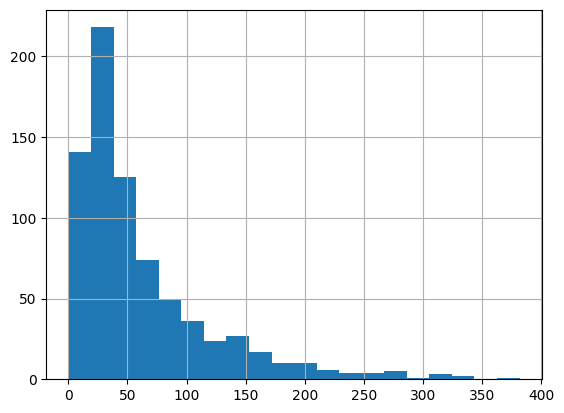

In [4]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

sum of ages: ~47123.10


<Axes: >

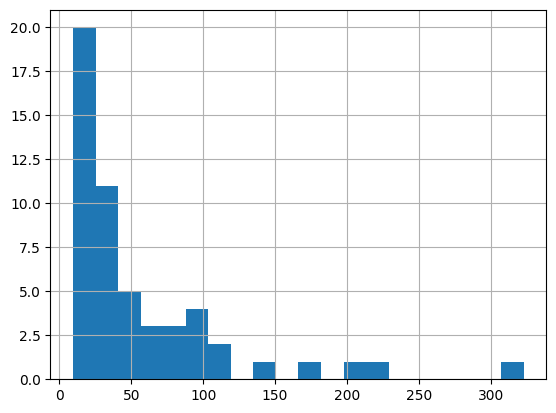

In [5]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards[existing_cards['head']=='Azure Developer Associate']['age'].hist(bins=20)

# Completely Random Shuffle

In [6]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [7]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# Headers with fewest notes first

In [8]:
# frequency = existing_cards['head'].value_counts(ascending=True)

# existing_cards = pd.merge(
#     left=existing_cards,
#     right=frequency.rename('frequency'),
#     left_on='head', right_index=True,
#     how='left'
# )
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] * -1
# existing_cards['age'] = existing_cards['age'] * -1


# existing_cards.sort_values(['frequency', 'subject_highest_age', 'age'], ascending=True, inplace=True)

# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)

# existing_cards.head(10)

## Headers with greatest age sum first

In [9]:
# existing_cards.sort_values(['subject_age_sum', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)
# existing_cards.head(10)

## Header with oldest cards first

In [10]:
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards.sort_values(['oldest', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# Focus on one header

In [11]:
# heads = existing_cards['head'].value_counts()
# heads = heads[heads > 5].index.tolist()
# one_header = random.sample(heads, 1)[0]
# existing_cards['pick_head'] = existing_cards['head'].apply(
#     lambda h: 0 if h == one_header else 1 
# )

# remake_card_document(existing_cards=existing_cards.sort_values('pick_head'))

## Headers with greatest mean card age first

In [12]:
# existing_cards.sort_values(['subject_mean_age', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# N-fold shuffle


## Age Sum

In [13]:
# n=3
# m=existing_cards.shape[0]//100
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Mean

In [14]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)

## Age Max

In [15]:
n = 3
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] % n

if existing_cards['age'].sum() > 0:
    existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
    existing_cards['neg_age'] = existing_cards['age'] *-1
existing_cards.sort_values(['n_fold', 'subject_highest_age', 'neg_age'], inplace=True)
# existing_cards.sort_values(['age'], inplace=True)

remake_card_document(existing_cards=existing_cards)
existing_cards.head(10)


Cards found: 758
Total card age: 47123.10


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,count,n_fold,neg_age
9,Terraform,terraform validate:\nA CLI command that checks...,036e232f01695e400da5847ea8babd0d,381.750049,83.504886,-381.750049,1586.592832,0.643810,19,0,0,-381.750049
10,Terraform,Ternary Operator (Conditional Expression):\nA ...,562077f9c53da73196fe84fee68b192c,119.943724,83.504886,-381.750049,1586.592832,0.643810,19,3,0,-119.943724
11,Terraform,Network Infrastructure Automation (NIA) allows...,926fae0c8984d1487f6df13e3f26a4bd,58.683127,83.504886,-381.750049,1586.592832,0.643810,19,6,0,-58.683127
12,Terraform,For Expressions:\n\nDefinition: These are used...,e4b58ae41b4f16b9449769c145f4fde7,51.678145,83.504886,-381.750049,1586.592832,0.643810,19,9,0,-51.678145
13,Terraform,List and Map Indexing:\nAccess elements within...,22da33af8995d10658804cf83eb7c1a4,49.407546,83.504886,-381.750049,1586.592832,0.643810,19,12,0,-49.407546
14,Terraform,Variable Declaration:\nUse the variable block ...,e40c2b457d12b8538128ba79185057b2,35.318708,83.504886,-381.750049,1586.592832,0.643810,19,15,0,-35.318708
15,Terraform,I used the following command to replace only o...,cc8c5876094d3d2c7982393c50952b16,4.025276,83.504886,-381.750049,1586.592832,0.643810,19,18,0,-4.025276
16,Python,Q:\nHow can you obtain command-line arguments ...,6a00d6335b8d45302a333e507237865b,340.258254,59.191901,-340.258254,3551.514055,0.391075,60,0,0,-340.258254
17,Python,Q:\nHow can you create a context manager using...,51557838e96944a86fd1f872036622f7,195.525329,59.191901,-340.258254,3551.514055,0.391075,60,3,0,-195.525329
18,Python,Q:\nWhat is a generator in Python?\n\nA:\nA fu...,6b53dc33f5a0f33e4199f7675802835a,154.688856,59.191901,-340.258254,3551.514055,0.391075,60,6,0,-154.688856


## Card Count

In [16]:
# n=5
# existing_cards['frequency']  = existing_cards.groupby('head').transform('count')['body']
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'frequency', 'subject_highest_age', 'neg_age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)


## Random

In [17]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [18]:
if existing_cards.age.sum() < 0:
    asc = True
else: asc = False
existing_cards.sort_values('age', ascending=asc).head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,count,n_fold,neg_age
9,Terraform,terraform validate:\nA CLI command that checks...,036e232f01695e400da5847ea8babd0d,381.750049,83.504886,-381.750049,1586.592832,0.643810,19,0,0,-381.750049
16,Python,Q:\nHow can you obtain command-line arguments ...,6a00d6335b8d45302a333e507237865b,340.258254,59.191901,-340.258254,3551.514055,0.391075,60,0,0,-340.258254
36,Asynchronous Python,asyncio.gather()\nRuns multiple asynchronous P...,88e88ee301ac734f3b1f136e405d3cfd,328.307937,90.540115,-328.307937,3712.144713,0.395853,41,0,0,-328.307937
69,Azure Developer Associate,Setting environment variables in your containe...,f6675da8ee24b7af11b76dd7d7bf7038,323.175523,57.914024,-323.175523,3069.443251,0.656347,53,0,0,-323.175523
50,C# Basics,What’s the difference between delegates and ev...,aafda82832da4aaff149c8153e06fc0a,323.009275,76.756295,-323.009275,2379.445144,0.606475,31,0,0,-323.009275
61,Azure DevOps Pipelines,"In Azure DevOps, what is the use of the strate...",22834b179fc5b8002c41682d03a4bac2,307.798721,92.888683,-307.798721,2229.328388,0.025654,24,0,0,-307.798721
250,FSLogix,"Cloud Cache uses the concept of a proxy file, ...",78203bab9238f47ee752697bba4135a5,297.746338,77.413841,-297.746338,2399.829068,0.945954,31,0,0,-297.746338
287,Asynchronous Python,asyncio.wait_for()\nRuns a coroutine with a ti...,0ccadcbce46e58eb4de4907f7e86cbf9,283.202162,90.540115,-328.307937,3712.144713,0.395853,41,1,1,-283.202162
532,Asynchronous Python,async with (async context manager)\nManages as...,359a45c84a774bead164891fd0454b3c,274.322962,90.540115,-328.307937,3712.144713,0.395853,41,2,2,-274.322962
267,Python,Q:\nWhich itertools function can be used to cr...,e10c94072687976e9627c8fc187d9ea3,272.691848,59.191901,-340.258254,3551.514055,0.391075,60,1,1,-272.691848


In [19]:
existing_cards['age'].mean()

62.16767382165929